# Import


In [47]:
#import aerosandbox as asb
#import aerosandbox.numpy as np
#import neuralfoil as nf
# from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd

# Step 1: Take off mass

In [48]:
g = 9.81 

eng_q = 2 
con_cell_num = 6 # количество параллельных ячеек в батарее
cell_U = 4.2 # Напряжение каждой ячейки
prop_D = 22 # Диаметрр пропеллера в дюймах

LD_ratio_cruise = 14 # Отношение подъемной силы к силы лобового сопротивления
prop_efficiency = 0.75 # КПД винта
battery_specific_energy = 216 
payload_mass = 1.5 # Масса полезной нагрузки
flight_time = 90 # Время полета в минутах
flight_time_hr = flight_time / 60 # Время полета в часах
cruise_speed = 90 # Скорость полета в км/ч
cruise_speed_ms = cruise_speed / 3.6 # Скорость полета в км/ч
takeoff_mass_reserve = 1.07 # Коэффициент запаса массы для взлета
battery_mass_reserve = 1.1 # Коэффициент запаса массы аккумулятора
k = 0.3 #
n = 2.3 #
prop_fasteners = 0.015 # коэффициент добавочной массы креплений в СУ
e = 0.78 # Коэффициент Освальда


## Zero approximation of takeoff mass

In [49]:
zero_apr_mass = 5.147 * (payload_mass ** 0.849)
zero_apr_weight = zero_apr_mass * g
print(zero_apr_mass)
print(zero_apr_weight)

7.26199001085213
71.2401220064594


## First approximation of takeoff mass

In [50]:
equipment_mass = 0.46
stat_structure_mass = zero_apr_mass * 0.3
req_power = zero_apr_weight * cruise_speed / LD_ratio_cruise / prop_efficiency
one_eng_power = req_power / eng_q
eng_mass = 0.889 * (one_eng_power ** -0.288) * ((con_cell_num * cell_U) **  0.1588)
prop_mass = k * (prop_D ** n) / 1000
power_mass = eng_mass + prop_mass + prop_fasteners
battery_mass = (req_power * flight_time_hr / battery_specific_energy) * battery_mass_reserve
m0_new1 = (payload_mass + stat_structure_mass + equipment_mass + power_mass + battery_mass) * takeoff_mass_reserve

print("First approximation takeoff mass (kg):", m0_new1)
print("Power required (W):", req_power)
print("Motor mass (kg):", eng_mass)
print("Propeller mass (kg):", prop_mass)
print("Power plant mass (kg):", power_mass)
print("Battery mass (kg):", battery_mass)
print("Structure mass (kg):", stat_structure_mass)

mass_diff = (zero_apr_mass - m0_new1) / (zero_apr_mass * 100)
print("Mass difference (%):", mass_diff)

First approximation takeoff mass (kg): 10.133759849953663
Power required (W): 610.6296171982234
Motor mass (kg): 0.28565167860570095
Propeller mass (kg): 0.36702311818421196
Power plant mass (kg): 0.6676747967899129
Battery mass (kg): 4.664531798041984
Structure mass (kg): 2.1785970032556388
Mass difference (%): -0.003954521880104536


## Second approximation of takeoff mass

In [51]:
zero_apr_mass = m0_new1
req_power = zero_apr_weight * cruise_speed / LD_ratio_cruise / prop_efficiency
one_eng_power = req_power / eng_q
eng_mass = 0.889 * (one_eng_power ** -0.288) * ((con_cell_num * cell_U) **  0.1588)
prop_mass = k * (prop_D ** n) / 1000
power_mass = eng_mass + prop_mass + prop_fasteners
battery_mass = (req_power * flight_time_hr / battery_specific_energy) * battery_mass_reserve
stat_structure_mass = zero_apr_mass * 0.3
m0_new2 = (payload_mass + stat_structure_mass + equipment_mass + power_mass + battery_mass) * takeoff_mass_reserve

print("\nSecond approximation takeoff mass (kg):", m0_new2)
print("Power required (W):", req_power)
print("Motor mass (kg):", eng_mass)
print("Propeller mass (kg):", prop_mass)
print("Power plant mass (kg):", power_mass)
print("Battery mass (kg):", battery_mass)
print("Structure mass (kg):", stat_structure_mass)

mass_diff = (zero_apr_mass - m0_new1) / (zero_apr_mass * 100)
print("Mass difference (%):", mass_diff)


Second approximation takeoff mass (kg): 11.055597968305257
Power required (W): 610.6296171982234
Motor mass (kg): 0.28565167860570095
Propeller mass (kg): 0.36702311818421196
Power plant mass (kg): 0.6676747967899129
Battery mass (kg): 4.664531798041984
Structure mass (kg): 3.0401279549860987
Mass difference (%): 0.0


# Step 2: Определение параметров завязки
## Input value 1

In [52]:
stall_speed = 55 # скорость сваливания (км/ч)
air_density_sea_level = 1.225 # плотность воздуха на взлете
max_lift_coefficient_stat = 1.4 # коэффициент подъемной силы крыла максимальный (по статистике)
min_lift_coefficient_stat = -0.8 # коэффициент подъемной силы крыла минимальный (по поляре профиля)
derivative_max_lift_coefficient_stat = 5.25 # производная CL (по поляре профиле)
WP = 0.1 # энерговооруженность (по прототипу)



## Calculation 1

In [53]:
stall_speed_ms = stall_speed / 3.6 # stall speed (m/s)
dynamic_pressuare = 0.5 * air_density_sea_level * stall_speed_ms ** 2 # Dynamic pressuare on stall 
wing_loading = max_lift_coefficient_stat * dynamic_pressuare # Wing loading on stall

print("Dynamic pressuare on stall:", dynamic_pressuare)
print("Wing loading on stall:", wing_loading)

Dynamic pressuare on stall: 142.9639274691358
Wing loading on stall: 200.1494984567901


## Calculation 2

In [54]:
take_off_weight = m0_new2 * g
S_wing = wing_loading / take_off_weight

print("Wing area (S):", S_wing)

Wing area (S): 1.8454541572116245


## Сalculation of battery parameters

In [55]:
series_cells_n = 6
parallel_cells_n = 4 
battery_weight = battery_mass * g
cell_U_min = 3
cell_U_max = 4.2
cell_capacity_nom_A = 4.2 
cell_capacity_nom_W = 15.5
max_current_cell = 45
cell_mass = 0.07
battery_mass_coef = 1.12

screws_n = 2
blades_n = 2
Kp = 0.0995

cell_total = series_cells_n * parallel_cells_n
pack_cell_U_min = series_cells_n * cell_U_min
pack_cell_U_max = series_cells_n * cell_U_max
pack_cell_U = series_cells_n * cell_U
pack_cell_capacity_nom_A = parallel_cells_n * cell_capacity_nom_A
pack_cell_capacity_nom_W = parallel_cells_n * cell_capacity_nom_W
pack_max_current_cell = parallel_cells_n * max_current_cell
pack_cell_mass = cell_total * cell_mass * battery_mass_coef
battery_pack_q = 1
total_battery_mass = pack_cell_mass * battery_pack_q
total_battery_capacity = battery_pack_q * pack_cell_capacity_nom_A

max_cell_q = battery_weight / battery_mass_coef / cell_mass

print("Емкость АБ:", pack_cell_capacity_nom_A, "А*ч")
print("Масса АБ:", total_battery_mass)
print("Емкость всех АБ при параллельном подключении:", total_battery_capacity, "А*ч")

Емкость АБ: 16.8 А*ч
Масса АБ: 1.8816000000000004
Емкость всех АБ при параллельном подключении: 16.8 А*ч


## Input value 3

In [56]:
Re_cruise = 511979
SwetS = 2 # Согласно таблице из источников
fric_coef = 0.74/(Re_cruise**0.2)
AR = 8 # Удлинение крыла
air_density_cruise = 1.1117
dynamic_viscosity_cruise = 0.00001787
prop_efficiency_cruise = 0.75
battery_depth = 0.3

## Calculation 3

In [57]:
zero_lift_drag_cruise = SwetS * fric_coef
induced_drag_factor_K = 0.3183 / AR / 0.78
wing_loading = wing_loading * 1
dynamic_pressuare_cruise = 0.5 * air_density_cruise * cruise_speed_ms ** 2
# aerodynamic_quality = 1 / ((dynamic_pressuare_cruise*Cd0 / wing_loading) * (wing_loading * K / dynamic_pressuare_cruise))
CL_opt = np.sqrt(zero_lift_drag_cruise / induced_drag_factor_K)
CD_opt = zero_lift_drag_cruise + induced_drag_factor_K * CL_opt**2
aerodynamic_quality = CL_opt / CD_opt

eng_efficiency = prop_efficiency * 0.95
MbatM0 = total_battery_mass / m0_new2
payload_weight = payload_mass * g

print(zero_lift_drag_cruise)
print("Cruise wing loading:", wing_loading, "H/m2")
print("Cruise dynamic pressuare:", dynamic_pressuare_cruise, "H/m2")
print("Aerodynamic quality L/D:", aerodynamic_quality)
print("Отношение массы батареи к массе всего БЛА в течении заданного времени:", MbatM0)

0.1067606688226137
Cruise wing loading: 200.1494984567901 H/m2
Cruise dynamic pressuare: 347.40625 H/m2
Aerodynamic quality L/D: 6.77545299895771
Отношение массы батареи к массе всего БЛА в течении заданного времени: 0.17019432195293874


## Input value 4

In [58]:
taper_ratio = 0.57
# fuselage_lenght = 
# fuselage_width =

## Calculation 4

In [59]:
wingspan = np.sqrt(AR * S_wing)
root_chord_lenght = (2 * S_wing) / (wingspan * (1 + taper_ratio))
tip_chord_lenght = taper_ratio * root_chord_lenght
# tip_chord_lenght = wingspan * root_chord_lenght
MAC = (2/3) * root_chord_lenght * (1 + taper_ratio + taper_ratio ** 2) / (1 + taper_ratio)

print(f"Wingspan: {wingspan:.3f} m")
print(f"Lenght of middle aerodynamic chord: {MAC:.3f} m")

Wingspan: 3.842 m
Lenght of middle aerodynamic chord: 0.492 m


# Step 3: Constant analysis

## VTOL UAV Constraint Diagram

### Fixed-Wing Mode

#### Stall speed
Wing loading for stall speed:

$$
\frac{W}{S} = \frac{1}{2} \rho V_s^2 C_{L_{\text{max}}}
$$

**Where:**
- $W/S$ = Wing loading (N/m²)
- $V_s$ = Stall speed (m/s)
- $C_{L_{\text{max}}}$ = Maximum lift coefficient
- $\rho$ = Air density (kg/m³)

#### Maximum Speed Constraint
Power loading for maximum speed:

$$
\frac{P}{W} = \frac{1}{\eta_p} \left( \frac{1}{2} \rho V_{\text{max}}^3 \frac{C_{D_0}}{W/S} + \frac{2K}{\rho V_{\text{max}}} \frac{W}{S} \right)
$$

**Where:**
- $\eta_p$ = Propeller efficiency
- $V_{\text{max}}$ = Maximum speed (m/s)
- $C_{D_0}$ = Zero-lift drag coefficient
mb rate (Tessure (Pa)
- $\theta$ = Tilt angle (degrees)
- $V$ = Transition speed (m/s)
- $k_i$ = Induced power correction factor

#### Rate of Climb Constraint
Power loading for climb rate:

$$
\frac{P}{W} = \frac{1}{\eta_p} \left( \frac{V_c}{V} + \frac{qC_{D_0}}{W/S} + \frac{K}{q} \frac{W}{S} \right)V
$$

**Where:**
- $V_c$ = Climb rate (m/s)
- $V$ = Flight speed (m/s)
- $q = \frac{1}{2}\rho V^2$ = Dynamic pressure (Pa)


The maximum rate of climb speed for the given wing loading:
$$
V_{\text{climb}} = \sqrt{\frac{2 \cdot (W/S)}{\rho}} \cdot \left( \frac{K}{C_{D_0}} \right)^{1/4}
$$

**Where:**
- $V_{\text{climb}}$ = Best climb speed (m/s)
- $W/S$ = Wing loading (N/m²)
- $\rho$ = Air density (kg/m³)
- $K$ = Induced drag factor
- $C_{D_0}$ = Zero-lift drag coefficient

#### Turn Constraint
Thrust-to-weight ratio for turn:

$$
\frac{T}{W} = q \left( \frac{C_{D_0}}{W/S} + \frac{K n^2}{q^2} \frac{W}{S} \right)
$$

Power loading for turn:

$$
\frac{P}{W} = \frac{1}{\eta_p} \left( \frac{T}{W} \cdot V \right) = \frac{1}{\eta_p} \left( q V \frac{C_{D_0}}{W/S} + \frac{K n^2 V}{q} \frac{W}{S} \right)
$$

**Where:**
- $T/W$ = Thrust-to-weight ratio
- $n$ = Load factor
- $q = \frac{1}{2} \rho V^2$ = Dynamic pressure (Pa)

#### Transition Mode Constraint

Power loading during transition:

$$
\frac{P}{W} = \frac{k_i}{\sin(\theta_{tilt})} \sqrt{\frac{-V_{inf}^2}{2} + \sqrt{\left(\frac{V_{inf}^2}{2}\right)^2 + \left(\frac{(DL)}{2\rho\sin(\theta_{tilt})}\right)^2}} + \frac{\rho V_{Tip}^3}{(DL)} \left(\frac{\sigma C_D}{8} (1 + 4.6\mu^2)\right) + \left(0.5\rho_0 V_{inf}^3 C_{D_0} \frac{1}{(W/S)} + \frac{2K}{\rho V_{inf}} (W/S)\right)
$$

**Where:**
- $q$ = Dynamic pressure (Pa)
- $\theta$ = Tilt angle (degrees)
- $V$ = Transition speed (m/s)
- $k_i$ = Induced power correction factor

533.7319958847736


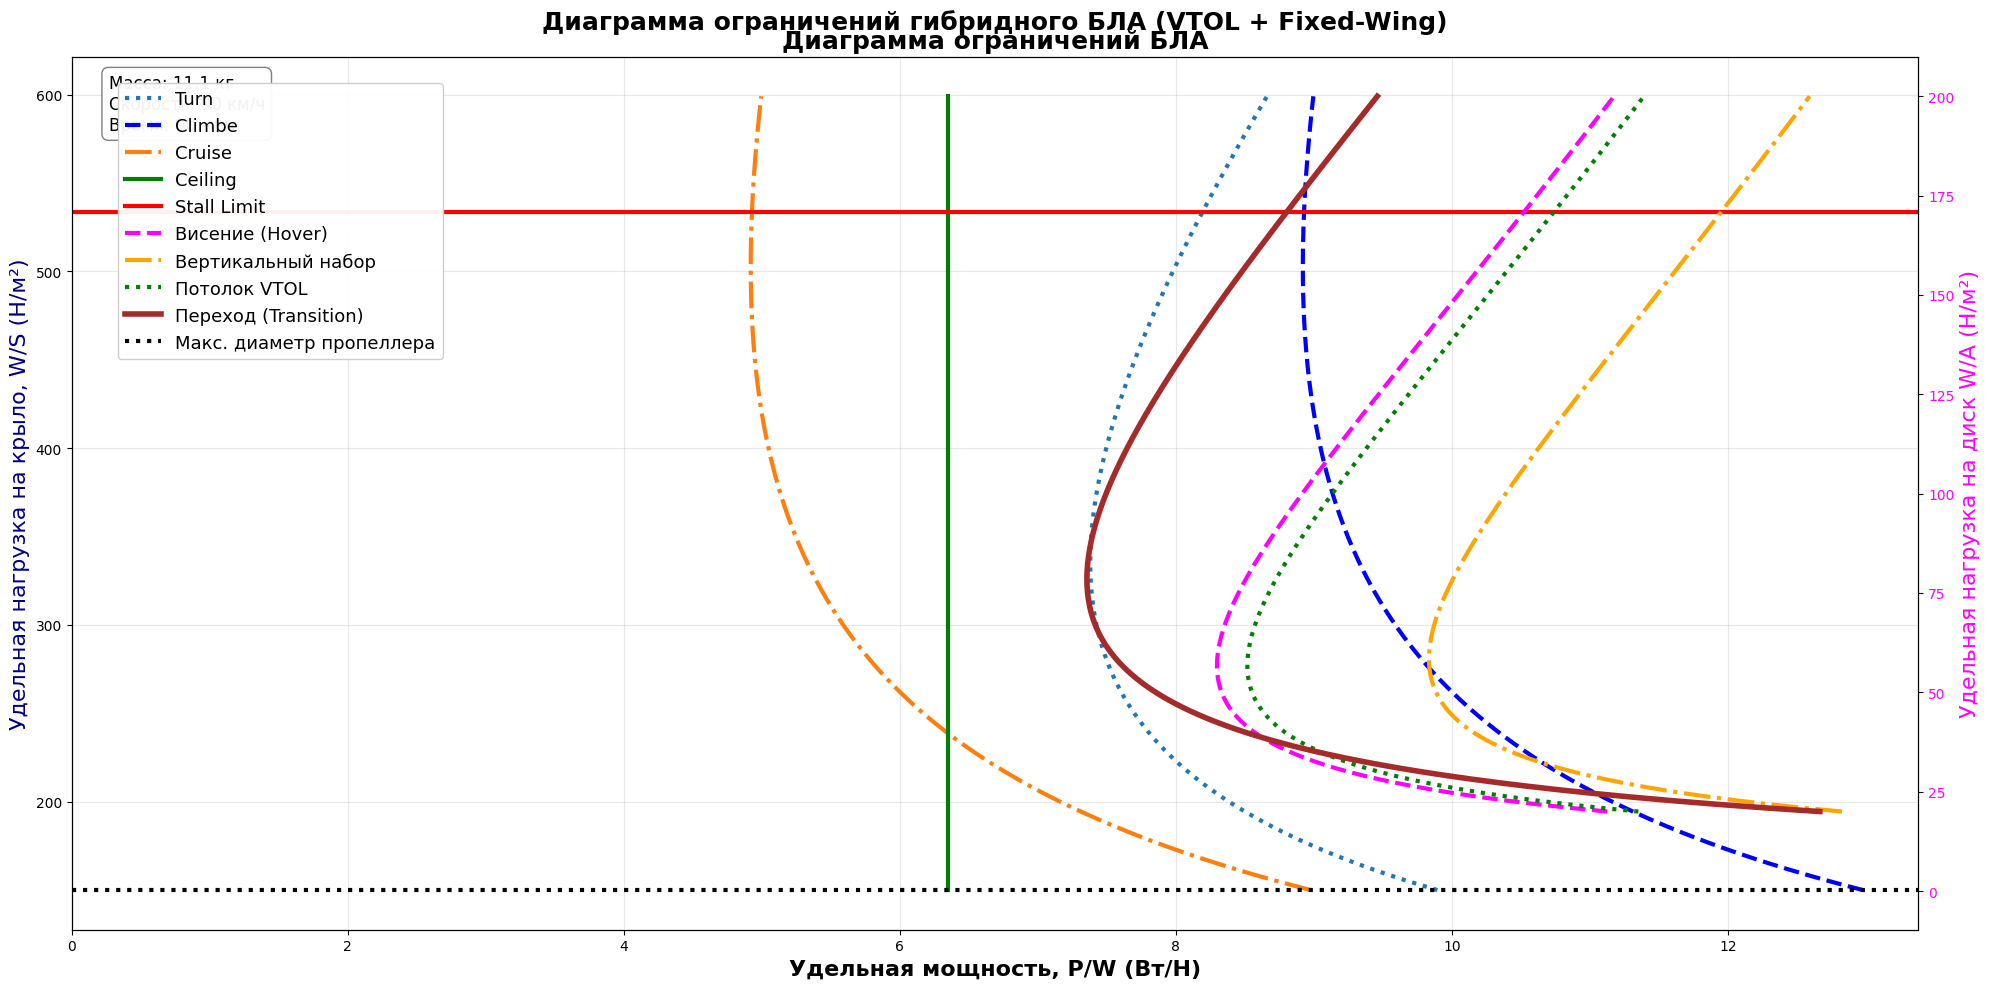

In [60]:
import matplotlib.pyplot as plt
import numpy as np

# Take-off weight base on mass from second approximation
weight_takeoff = m0_new2 * g

# Speed on transition
Vinf = stall_speed_ms
Vy_hover = 0.0
Vy_climb = 3.0
Vy_ceiling = 0.5

# Prop characteristics
Vtip = 80  # м/с
solidity = 0.1
Cd_blade = 0.02
induced_power_factor_hover = 1.15
induced_power_factor_climb = 1.15
disc_loading_max_diameter = 0.246

# Angels
teta_tilt_90 = np.pi / 2
alpha_rotor_trans = 0
V_tip_transition_helical = np.sqrt(Vtip**2 + Vinf**2)
mu = Vinf * np.cos(alpha_rotor_trans) / V_tip_transition_helical

# Wing aerodynamic
wing_loading_optimum_airborne = 300  # Н/м²

climbe_rate = 3 # m/s
ceiling_rate_of_climb = 0.5 # m/s
max_lift_coefficient = 1.4

# Wing loading on stall
wing_loading_stall = max_lift_coefficient*(air_density_sea_level*stall_speed_ms**2)/prop_efficiency
print(wing_loading_stall)

# Range of applyable wing loading in N/m^2
wing_loading_range = np.arange(150, 600, 1, dtype=float)

# Initialize arrays for storing results as floats
power_loading_turn_P_W = np.zeros_like(wing_loading_range, dtype=float)
power_loading_cruise_P_W = np.zeros_like(wing_loading_range, dtype=float)
power_loading_climb_P_W = np.zeros_like(wing_loading_range, dtype=float)
power_loading_ceiling_P_W = np.zeros_like(wing_loading_range, dtype=float)

q = 0.5 * air_density_cruise * cruise_speed_ms**2
n_load = 1.5 # Overload on wing

# Horizontal mode calculation
# Power loading on cruise speed and altitude 
def pw_cruise(wl): 
    return (cruise_speed_ms / prop_efficiency) * (q * zero_lift_drag_cruise / wl + induced_drag_factor_K * wl / q)

# Power loading on velcoity turn
def pw_turn(wl): 
    return (cruise_speed_ms / prop_efficiency) * (q * zero_lift_drag_cruise / wl + induced_drag_factor_K * n_load**2 * wl / q)

# Power loading on climb
def pw_climb(wl): 
    return (3.0 / prop_efficiency) + (cruise_speed_ms / prop_efficiency) * (q * zero_lift_drag_cruise / wl + induced_drag_factor_K * wl / q)

# Power loading on ceiling
def pw_ceiling(wl): 
    return (0.5 / prop_efficiency) + (cruise_speed_ms / prop_efficiency) * 4 * np.sqrt(induced_drag_factor_K * zero_lift_drag_cruise / 3)

# Inserting values into arrays
for i, wing_loading_dif in enumerate(wing_loading_range):
    power_loading_cruise_P_W[i] = pw_cruise(wing_loading_dif)
    power_loading_turn_P_W[i] = pw_turn(wing_loading_dif)
    power_loading_climb_P_W[i] = pw_climb(wing_loading_dif)
    power_loading_ceiling_P_W[i] = pw_ceiling(wing_loading_dif)

# Vertical mode calculation
# Power loading on hover
def pw_hover(disc_loading):
    A = weight_takeoff / disc_loading
    P_ind = induced_power_factor_hover * np.sqrt(weight_takeoff) / np.sqrt(2 * air_density_sea_level * A)
    P_prof = air_density_sea_level * A * Vtip**3 * solidity * Cd_blade / (8 * weight_takeoff)
    return P_ind + P_prof

# Power loading on climb
def pw_vertical_climb(disc_loading, Vy):
    term1 = Vy * (1 - induced_power_factor_climb / 2)
    term2 = (induced_power_factor_climb / 2) * np.sqrt(Vy**2 + 2 * disc_loading / air_density_sea_level)
    term3 = air_density_sea_level * Vtip**3 * solidity * Cd_blade / (8 * disc_loading)
    return term1 + term2 + term3

#Power loading on transition
def pw_transition(disc_loading):
    term1 = 1.2 / np.sin(teta_tilt_90) * np.sqrt(-Vinf**2 / 2 + np.sqrt((Vinf**2 / 2)**2 + (disc_loading / (2 * air_density_sea_level * np.sin(teta_tilt_90)))**2))
    term2 = (air_density_sea_level * V_tip_transition_helical**3 / disc_loading * (solidity * Cd_blade / 8 * (1 + 4.6 * mu**2)))
    term3 = (0.5 * air_density_sea_level * Vinf**3 * zero_lift_drag_cruise / wing_loading_optimum_airborne + 2 * induced_drag_factor_K * wing_loading_optimum_airborne / (air_density_sea_level * Vinf))
    return term1 + term2 + term3


disc_loading_range = np.linspace(20, 200, 200)  # Н/м²

# Inserting values for vertical mode into array
pw_hover_arr = np.array([pw_hover(dl) for dl in disc_loading_range])
pw_vclimb_arr = np.array([pw_vertical_climb(dl, Vy_climb) for dl in disc_loading_range])
pw_vceiling_arr = np.array([pw_vertical_climb(dl, Vy_ceiling) for dl in disc_loading_range])
pw_trans_arr = np.array([pw_transition(dl) for dl in disc_loading_range])

# Creating of diagram
fig, ax1 = plt.subplots(figsize=(20, 10))

# Левая ось: Wing Loading (W/S) vs P/W
ax1.plot(power_loading_turn_P_W, wing_loading_range, ':', linewidth=3, label='Turn')
ax1.plot(power_loading_climb_P_W, wing_loading_range, '--', color='blue', linewidth=3, label='Climbe')
ax1.plot(power_loading_cruise_P_W, wing_loading_range, '-.', linewidth=3, label='Cruise')
ax1.plot(power_loading_ceiling_P_W, wing_loading_range, '-', color='green', linewidth=3, label='Ceiling')

ax1.axhline(y=wing_loading_stall, color='red', linewidth=3, label='Stall Limit')

ax1.set_xlabel('Удельная мощность, P/W (Вт/Н)', fontsize=16, fontweight='bold')
ax1.set_ylabel('Удельная нагрузка на крыло, W/S (Н/м²)', fontsize=16, color='navy')
ax1.set_title('Диаграмма ограничений БЛА', fontsize=18, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.set_xlim(left=0)  # Убираем отрицательные значения
# ax1.set_ylim(150, 600)

# ax1.legend(fontsize=14, loc='upper left', frameon=True, fancybox=True, shadow=True)

# plt.tight_layout()
# plt.show()

ax2 = ax1.twinx()

ax2.plot(pw_hover_arr, disc_loading_range, '--', color='magenta', lw=3, label='Висение (Hover)')
ax2.plot(pw_vclimb_arr, disc_loading_range, '-.', color='orange', lw=3, label='Вертикальный набор')
ax2.plot(pw_vceiling_arr, disc_loading_range, ':', color='green', lw=3, label='Потолок VTOL')
ax2.plot(pw_trans_arr, disc_loading_range, '-', color='brown', lw=4, label='Переход (Transition)')

# Геометрическое ограничение
ax2.axhline(y=disc_loading_max_diameter, color='black', linestyle=':', lw=3, label='Макс. диаметр пропеллера')

ax2.set_ylabel('Удельная нагрузка на диск W/A (Н/м²)', fontsize=16, color='magenta')
ax2.tick_params(axis='y', labelcolor='magenta')

# === ЛЕГЕНДА ===
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, 
           loc='upper left', bbox_to_anchor=(0.02, 0.98), fontsize=13, framealpha=0.95)

# === АННОТАЦИИ ===
ax1.text(0.02, 0.98, f"Масса: {m0_new2:.1f} кг\nСкорость: {cruise_speed} км/ч\nВремя: {flight_time} мин",
         transform=ax1.transAxes, fontsize=12, verticalalignment='top',
         bbox=dict(boxstyle="round,pad=0.4", facecolor="white", edgecolor="gray"))

plt.title('Диаграмма ограничений гибридного БЛА (VTOL + Fixed-Wing)', 
          fontsize=18, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Step 4: Wing profile

In [61]:
number_point_on_chord = 30
phi = math.radians(90 / (number_point_on_chord - 1))
profile_thickness = 0.12
profile_curv = 0.04
max_curv_point = 0.4
zero_lift_angel = -90 * profile_curv

# max_lift_coefficient - maximum lift coefficient by statistic for this UAV class
profile_max_lift_coefficient = 1.55
critical_attack_angel_profile = zero_lift_angel + profile_max_lift_coefficient / (2*np.pi) * 57.3 + 2
print(critical_attack_angel_profile)

# Functions for wing profile calculation
def phi_profile_angel(n):
    return phi * (n - 1)

def x_profile(n):
    return 1 - np.cos((n-1)*phi)

def ytx_profile(x):
    return 5 * profile_thickness * (0.2969 * x ** 0.5 - 0.126 * x - 0.3516 * x ** 2 + 0.2843 * x ** 3 - 0.1015 * x ** 4)

def ycx_profile(x):
    if x <= max_curv_point:
        res = profile_curv * (2 * max_curv_point - n) * n / (max_curv_point ** 2)
    else:
        res = profile_curv * ((1 - 2 * max_curv_point) + 2 * max_curv_point * x - x ** 2) / (1 - max_curv_point) ** 2
    return res

def yc1t_profile(x):
    if x <= max_curv_point:
        res = 2 * profile_curv / max_curv_point * (1 - x / max_curv_point)
    else:
        res = 2 * profile_curv * (max_curv_point - x) / (1 - max_curv_point) ** 2
    return res

def theta(y1):
    return np.arctan(y1)

def x_upper_profile(x, ytx, θ):
    return x - ytx * np.sin(θ)

def x_lower_profile(x, ytx, θ):
    return x + ytx * np.cos(θ)

def y_upper_profile(ycx, ytx, θ):
    return ycx + ytx  * np.cos(θ)

def y_lower_profile(ycx, ytx, θ):
    return ycx - ytx * np.cos(θ)

# Creating range for arrays
n_points = range(1, number_point_on_chord + 1)

# Creating and filling arrays
phi_profile_angel_arr = np.array([phi_profile_angel(n) for n in n_points])
x_profile_arr = np.array([x_profile(n) for n in n_points])
# ytx_profile_arr = np.array([ytx_profile(x_profile_arr[i]) for i in range(len(n_points))])
ytx_profile_arr = np.array([ytx_profile(x) for x in x_profile_arr])
ycx_profile_arr = np.array([ycx_profile(x) for x in x_profile_arr])
yc1t_profile_arr = np.array([yc1t_profile(x) for x in x_profile_arr])
theta_arr = np.array([theta(yc1t) for yc1t in yc1t_profile_arr])

x_upper_profile_arr = np.array([x_upper_profile(x_profile_arr[i], ytx_profile_arr[i], theta_arr[i]) for i in range(len(n_points))])
x_lower_profile_arr = np.array([x_lower_profile(x_profile_arr[i], ytx_profile_arr[i], theta_arr[i]) for i in range(len(n_points))])
y_upper_profile_arr = np.array([y_upper_profile(ycx_profile_arr[i], ytx_profile_arr[i], theta_arr[i]) for i in range(len(n_points))])
y_lower_profile_arr = np.array([y_lower_profile(ycx_profile_arr[i], ytx_profile_arr[i], theta_arr[i]) for i in range(len(n_points))])

data = {
    'n': n_points,
    'φ': phi_profile_angel_arr,
    'x': x_profile_arr,
    'yt(x)': ytx_profile_arr,
    'yc(x)': ycx_profile_arr,
    'yc\'(x)': yc1t_profile_arr,
    'θ': theta_arr,
    'x_upper': x_upper_profile_arr,
    'x_lower': x_lower_profile_arr,
    'y_upper': y_upper_profile_arr,
    'y_lower': y_lower_profile_arr
}

df = pd.DataFrame(data)

# Форматирование вывода
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

print("Таблица параметров аэродинамического профиля:")
print("=" * 100)
print(df.round(6))
print("\n")

# Альтернативный вывод в стиле вашего файла
print("Форматированная таблица:")
print("n\tx\t\tyt(x)\t\tyc(x)\t\tyc'(x)\t\tθ\t\tx_upper\t\ty_upper\t\tx_lower\t\ty_lower")
print("-" * 120)
for i in range(len(n_points)):
    print(f"{n_points[i]}\t{x_profile_arr[i]:.6f}\t{ytx_profile_arr[i]:.6f}\t{ycx_profile_arr[i]:.6f}\t"
          f"{yc1t_profile_arr[i]:.6f}\t{theta_arr[i]:.6f}\t{x_upper_profile_arr[i]:.6f}\t"
          f"{y_upper_profile_arr[i]:.6f}\t{x_lower_profile_arr[i]:.6f}\t{y_lower_profile_arr[i]:.6f}")

12.535346270706686
Таблица параметров аэродинамического профиля:
     n         φ         x     yt(x)     yc(x)    yc'(x)         θ   x_upper  \
0    1  0.000000  0.000000  0.000000 -0.862500  0.200000  0.197396  0.000000   
1    2  0.054165  0.001467  0.006711 -0.862500  0.199267  0.196690  0.000155   
2    3  0.108331  0.005862  0.013189 -0.862500  0.197069  0.194576  0.003312   
3    4  0.162496  0.013173  0.019414 -0.862500  0.193413  0.191054  0.009487   
4    5  0.216662  0.023379  0.025358 -0.862500  0.188310  0.186131  0.018687   
5    6  0.270827  0.036450  0.030983 -0.862500  0.181775  0.179812  0.030909   
6    7  0.324992  0.052347  0.036246 -0.862500  0.173827  0.172107  0.046139   
7    8  0.379158  0.071023  0.041101 -0.862500  0.164488  0.163028  0.064352   
8    9  0.433323  0.092425  0.045498 -0.862500  0.153788  0.152592  0.085509   
9   10  0.487489  0.116488  0.049389 -0.862500  0.141756  0.140818  0.109556   
10  11  0.541654  0.143143  0.052728 -0.862500  0.12842

# Step 5: Wing characteristics

Calculation of unmanned aerial vehicle wing characteristics. Finding MAC.

Таблица поляры крыла:
 Коэффициент подъёмной силы  Коэффициент лобового сопротивления
              -8.000000e-01                            0.135664
              -7.900000e-01                            0.134946
              -7.800000e-01                            0.134237
              -7.700000e-01                            0.133537
              -7.600000e-01                            0.132846
              -7.500000e-01                            0.132164
              -7.400000e-01                            0.131491
              -7.300000e-01                            0.130827
              -7.200000e-01                            0.130172
              -7.100000e-01                            0.129526
              -7.000000e-01                            0.128890
              -6.900000e-01                            0.128262
              -6.800000e-01                            0.127643
              -6.700000e-01                            0.127033
              -6.6

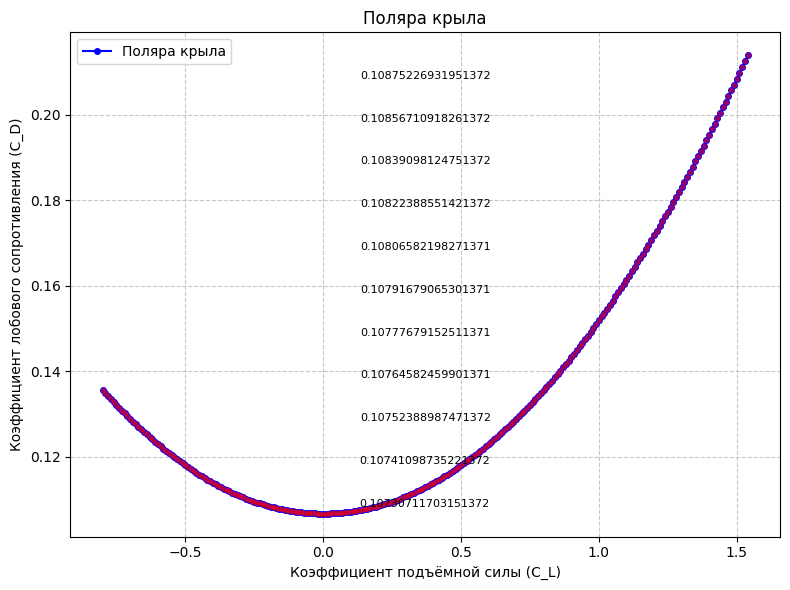

In [63]:
wing_narrowing = 0.5
sweep_angel_1_2 = 0
angel_of_incedence = 0
dihedral_angel = 0
wing_tip_twist = 0
root_sweep_angel = 90 - np.arctan(wingspan / (root_chord_lenght - tip_chord_lenght))
x_coor_root_MAC = wingspan / 6 * (2 * wing_narrowing + 1) / (wing_narrowing + 1)
y_coor_root_MAC = root_sweep_angel*np.arctan(x_coor_root_MAC)

zero_lift_angel_of_attack = zero_lift_angel + angel_of_incedence
kl = -0.0125 * (1 / wing_narrowing) ** 2 + 0.0675 * (1 / wing_narrowing) + 0.8475
max_lift_coefficient_wing = 0.5 * kl * (1 + np.cos(np.radians(wing_tip_twist))) * profile_max_lift_coefficient
derivative_lift_coefficient_wing = 2 * np.pi * AR * np.cos(np.radians(wing_tip_twist)) / (2 + AR)
critical_attack_angel_wing = zero_lift_angel_of_attack + max_lift_coefficient_wing / derivative_lift_coefficient_wing * 57.3

over_lift_angel = 1.15 * critical_attack_angel_wing
over_lift_coefficient_wing = (over_lift_angel + zero_lift_angel_of_attack) * derivative_lift_coefficient_wing / 57.3

# Plotting the wing polar graph
drag_coefficient_constant = 0.045161009
wing_lift_coefficient_array = np.arange(-0.8, max_lift_coefficient_wing + 0.1, 0.01)

def wing_drag_coefficient(CL):
    return zero_lift_drag_cruise + CL ** 2 * drag_coefficient_constant

wing_drag_coefficient_array = wing_drag_coefficient(wing_lift_coefficient_array)

data = {
    "Коэффициент подъёмной силы": wing_lift_coefficient_array,
    "Коэффициент лобового сопротивления": wing_drag_coefficient_array
}
df = pd.DataFrame(data)

# === ШАГ 7: Выводим таблицу ===
print("Таблица поляры крыла:")
print(df.to_string(index=False))

# === ШАГ 8: Строим график ===
plt.figure(figsize=(8, 6))
plt.plot(wing_lift_coefficient_array, wing_drag_coefficient_array, 'b-o', label='Поляра крыла', markersize=4)
plt.plot(wing_lift_coefficient_array, wing_drag_coefficient_array, 'ro', alpha=0.5, markersize=3)  # точки из таблицы

plt.ylabel('Коэффициент лобового сопротивления (C_D)')
plt.xlabel('Коэффициент подъёмной силы (C_L)')
plt.title('Поляра крыла')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

# Добавляем аннотации для ключевых точек (опционально)
for cl, cd in zip(wing_lift_coefficient_array, wing_drag_coefficient_array):
    if cl >= 0:  # только положительные C_L
        plt.annotate(f'{cd}', (cd, cl), textcoords="offset points", xytext=(5,-5), ha='left', fontsize=8)

plt.tight_layout()
plt.show()